# SV2TTS Tacotron-2 training

This notebook shows how to create (with *partial transfer learning*), train and use a `SV2TTS` architecture

## Imports + model creation

In [1]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf

from models.tts import SV2TTSTacotron2, PtWaveGlow
from custom_architectures import get_architecture
from datasets import get_dataset, train_test_split
from utils import plot_spectrogram, select_embedding, limit_gpu_memory
from utils.text import default_french_encoder
from utils.audio import display_audio, load_audio

gpus = tf.config.list_physical_devices('GPU')

rate = 22050
model_name = 'sv2tts_tacotron2_256'

print("Tensorflow version : {}".format(tf.__version__))
print("Available GPU's : {}".format(gpus))

Tensorflow version : 2.3.2
Available GPU's : [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# This special cleaner allow to not lowercase the text 
# see my data_processing repository for more examples on text encoding / cleaners
# If you want lowercase, you just have to remove the "cleaners" argument from default_french_encoder()
cleaners = [
    'fr_convert_to_ascii',
    {'name' : 'expand_numbers', 'langue' : 'fr'},
    'collapse_whitespace'
]

encoder = default_french_encoder(vocab_size = 148, cleaners = cleaners)
print(encoder)

config = {
    'nom' : model_name,
    'new_lang' : 'fr',
    'new_encoder' : encoder,
    'speaker_encoder_name'  : 'audio_siamese_256_mel_lstm',
    'speaker_embedding_dim' : 256,
    'use_utterance_embedding' : True
}

In [ ]:
model = SV2TTSTacotron2.build_from_nvidia_pretrained(** config)
print(model)


In [ ]:
model = SV2TTSTacotron2.build_from_pretrained(pretrained_name = 'tacotron2_siwis', ** config)
print(model)


In [ ]:
pretrained_name = 'sv2tts_tacotron2'

model = SV2TTSTacotron2.build_from_sv2tts_pretrained(
    nom = config['nom'], pretrained_name = pretrained_name, langue = config['new_lang'],
    text_encoder = config['new_encoder'], speaker_embedding_dim = config['speaker_embedding_dim']
)
print(model)


## Model initialization + dataset loading

In [ ]:
model = SV2TTSTacotron2(nom = model_name)

lr = { 'name': 'WarmupScheduler', 'maxval' : 75e-5, 'minval' : 25e-5, 'factor' : 1024, 'warmup_steps' : 2048}
#lr = 5e-4

model.compile(
    optimizer = 'adam', 
    optimizer_config = {'lr' : lr}
)

print(model)

In [ ]:
kwargs = {
    'embedding_dim'  : model.speaker_embedding_dim,
    'embedding_name' : 'embeddings_256_mel_lstm.csv'}

datasets = ['siwis', 'voxforge', 'common_voice']

dataset = get_dataset(
    datasets, accent = 'france', shuffle = True, ** kwargs
)
# If the dataset is a dict, it is typically a STT dataset where
# validation set contains "new speakers" but it is not relevant for this model
# because generalization to new speakers is really hard and only interesting if datasets
# have many speakers (>> 1k) (which is really rare in TTS datasets)
if isinstance(dataset, dict): dataset = dataset['train']
#dataset = filter_dataset(dataset, duree = lambda d: d < 11)

print("Dataset length : {} ({} speakers)".format(
    len(dataset), len(dataset['id'].unique())
))


## Training

In [ ]:
epochs          = 7
batch_size      = 32
valid_batch_size    = batch_size

max_valid_size  = min(int(0.1 * len(dataset)), 256 * valid_batch_size)

train_size      = min(1024 * batch_size, len(dataset) - max_valid_size)
valid_size      = min(len(dataset) - train_size, max_valid_size)

shuffle_size    = batch_size * 12
pred_step       = 512

""" Custom training hparams """
augment_prct        = 0.25
augment_speaker_embedding   = False

trim_audio      = True
reduce_noise    = True if 'common_voice' in datasets else False
trim_threshold  = 0.075
max_silence     = 0.1
trim_method     = 'window'
trim_mode       = 'start_end'

trim_mel     = False
trim_factor  = 0.6
trim_mel_method  = 'max_start_end'

# Seems to be interesting for single-speaker fine-tuning
# and for a better generalization but seems to slow down convergence 
use_utterance_embedding = True

max_input_length = 75
max_output_length = 512

""" Training """

train, valid = train_test_split(
    dataset, train_size = train_size, valid_size = valid_size, shuffle = True
)

print("Training samples   : {} - {} batches - {} speakers".format(
    len(train), len(train) // batch_size, len(train['id'].unique())
))
print("Validation samples : {} - {} batches - {} speakers".format(
    len(valid), len(valid) // valid_batch_size, len(valid['id'].unique())
))

# This feature seems interesting for singl-speaker fine-tuning
# If you want to enable it, put `trainable = False`
trainable = False
if model.epochs >= 5:
    model.tts_model.postnet.trainable = trainable
if model.epochs >= 10:
    model.tts_model.encoder.trainable = trainable

model.train(
    train, validation_data = valid, 
    epochs = epochs, batch_size = batch_size, valid_batch_size = valid_batch_size,

    max_input_length = max_input_length, max_output_length = max_output_length,
    shuffle_size = shuffle_size, pred_step = pred_step,
    augment_prct = augment_prct, augment_speaker_embedding = augment_speaker_embedding,
    
    trim_audio = trim_audio, reduce_noise = reduce_noise, trim_threshold = trim_threshold,
    max_silence = max_silence, trim_method = trim_method, trim_mode = trim_mode,
    
    trim_mel = trim_mel, trim_factor = trim_factor, trim_mel_method = trim_mel_method,
    
    use_utterance_embedding = use_utterance_embedding
)



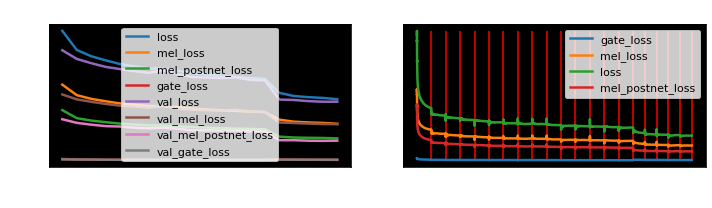

===== History =====
        loss  mel_loss  mel_postnet_loss  gate_loss  val_loss  val_mel_loss  \
0   0.660436  0.388381          0.259517   0.012538  0.562435      0.338751   
1   0.564001  0.335179          0.218913   0.009910  0.518525      0.313924   
2   0.532067  0.316438          0.206509   0.009120  0.496940      0.301493   
3   0.511372  0.304260          0.198491   0.008622  0.478202      0.290929   
4   0.492413  0.293110          0.191179   0.008125  0.467004      0.282009   
5   0.480428  0.286260          0.186373   0.007795  0.456441      0.277925   
6   0.469920  0.280151          0.182262   0.007507  0.448420      0.272521   
7   0.469509  0.280280          0.181685   0.007544  0.461285      0.282307   
8   0.458880  0.274109          0.177733   0.007038  0.440313      0.266923   
9   0.446992  0.266951          0.173385   0.006655  0.426718      0.261761   
10  0.439494  0.262525          0.170582   0.006387  0.424575      0.259221   
11  0.433239  0.258778          

In [6]:
model.plot_history()
print(model.history)

## Prediction / inference

### Prediction with target

This cell allows you to make prediction **with** target : it means the model will have an inference and a prediction (as during training)

Next you can make the `waveglow inference` with the section related to `prediction on training generated` (you just have to replace `mode = 'train'` by `mode = 'pred'`)

In [ ]:
config = model.get_dataset_config(batch_size = 1, cache = False, is_validation = True)

sub_ds = valid.sample(15, random_state = 1024)
ds = prepare_dataset(sub_ds, ** config)

for i, batch in enumerate(ds):
    model.predict_with_target(
        batch, step = 'test', prefix = 'pred_{}'.format(i),
        directory = model.pred_dir, show = True
    )


### Prediction without target

This cell will allow you to make prediction **without** target (ie by putting the text you want) !

Note that this 1st cell is to set the default embeddings to use in prediction : it is also **necessary** for `Waveglow inference` (with the `tts` API) (see the `waveglow` notebook)

In [ ]:
kwargs = {
    'embedding_dim'  : model.speaker_embedding_dim,
    'embedding_name' : 'embeddings_256_mel_lstm.csv'
}

datasets = 'siwis'

dataset = get_dataset(datasets, ** kwargs)

embeddings = dataset.sample(10)
model.set_default_embeddings(embeddings)

In [ ]:
text = "Bonjour le monde !"

model.predict(text, overwrite = True, debug = True, save = True)

## Complete inference

These cells allow you to test your model with a complete inference pipeline

Note that you have to restart your kernel then execute 1st cell (imports) then cells below. You **must** first instanciate the `PtWaveGlow` model which will call `limit_gpu_memory` to reduce visible GPU memory for tensorflow (to allow a better coexistance of both libraries). 

As you can see in this demonstration, the model tends to speak with the `SIWIS` voice even ifanother is required. The model has not been trained enough for good cloning but still can speak and is a good base for fine-tuning. 

In [ ]:
waveglow = PtWaveGlow()
model    = SV2TTSTacotron2(nom = model_name)

In [3]:
def full_inference(text, embedding, n = 1):
    encoded = tf.expand_dims(model.encode_text(text), axis = 0)
    
    _, mel, _, attn = model.infer(
        encoded, [tf.shape(encoded)[1]], embedding
    )
    
    mel = np.squeeze(mel, 0)
    
    plot_spectrogram(inference = mel, attention = attn)
    audio = waveglow.infer(mel)

    display_audio(audio, rate = rate)
    return audio

kwargs = {
    'embedding_dim'  : model.speaker_embedding_dim,
    'embedding_name' : 'embeddings_256_mel_lstm_old.csv'
}

datasets = ['siwis', 'voxforge']

dataset = get_dataset(
    datasets, accent = 'france', shuffle = True, ** kwargs
)

Loading dataset siwis...
Loading dataset voxforge...


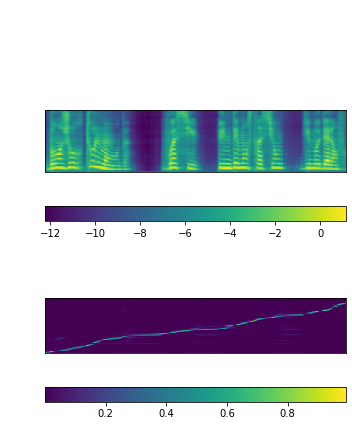

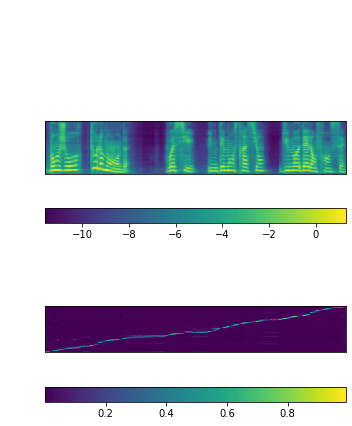

In [5]:
text = "Bonjour tout le monde ! Voici une démonstration du modèle en français."

# Select an embedding and display original speaker audio associated to this embedding
x = random.randrange(0, len(dataset))
display_audio(dataset.at[x, 'filename'])
embedding = select_embedding(dataset, mode = x)

silence = np.zeros((int(rate * 0.15),))
audios = []
if not isinstance(text, list): text = [text]

for p in text:
    for _ in range(2):
        audio = full_inference(p, embedding)
    audios.append(audio)
    audios.append(silence)

if len(text) > 1:
    audios = np.concatenate(audios)
    _ = display_audio(audios, rate)

## Waveglow inference on training generated audios

This is a demonstration on prediction at step 500 so it is normal that inference is so bad ;)

In [ ]:
def infer_with_target(model_name, step, n, mode, save = False, display = True):
    if mode == 'train':
        directory = os.path.join('pretrained_models', model_name, 'training-logs', 'eval', 'mels')
        filename = 'pred_step-{:06d}_{}_target.npy'.format(step, n)
        pred_filename = 'pred_step-{:06d}_{}_pred.npy'.format(step, n)
        infer_filename = 'pred_step-{:06d}_{}_infer.npy'.format(step, n)
    else:
        directory = os.path.join('pretrained_models', model_name, 'outputs', 'mels')
        filename = 'pred_{}_target.npy'.format(n)
        pred_filename = 'pred_{}_pred.npy'.format(n)
        infer_filename = 'pred_{}_infer.npy'.format(n)

    if not os.path.exists(os.path.join(directory, filename)): return
    
    target = np.load(os.path.join(directory, filename))
    pred   = np.load(os.path.join(directory, pred_filename))
    infer  = np.load(os.path.join(directory, infer_filename))
    
    audio       = waveglow.infer(target)
    audio_pred  = waveglow.infer(pred)
    audio_infer = waveglow.infer(infer)

    _ = display_audio(audio, rate = rate)
    _ = display_audio(audio_pred, rate = rate)
    _ = display_audio(audio_infer, rate = rate)
    
    if save:
        save_dir = directory.replace('mels', 'audios')
        os.makedirs(save_dir, exist_ok = True)
        write_audio(audio, os.path.join(save_dir, filename[:-3] + 'mp3'), rate = rate)
        write_audio(audio_pred, os.path.join(save_dir, pred_filename[:-3] + 'mp3'), rate = rate)
        write_audio(audio_infer, os.path.join(save_dir, infer_filename[:-3] + 'mp3'), rate = rate)
    
    plot_spectrogram(
        target = target, prediction = pred, inference = infer
    )

waveglow = get_architecture('nvidia_waveglow')

In [ ]:
step, mode = 500, 'train'

for n in range(5):
    infer_with_target(model_name, step, n, mode)


## Tests

In [ ]:
from custom_train_objects.optimizers import WarmupScheduler

lr = WarmupScheduler(maxval = 75e-5, minval = 25e-5, factor = 1024)
print(lr.get_config())
lr.plot(1024 * 10)